In [46]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Some more imports  

In [47]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import QFT
from qiskit.opflow import X,Y,Z,I,CX
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# Three Quantum Phase estimators are defined to compare on the same evolution matrix : 1st in-built QPE, 2nd my_qpe, 3rd QPE by DavidKach(Github)

# 2nd QPE : Defining matrix to control gate convertor, Quantum Phase Estimator and result.count to eigen value convertor

In [57]:
#Operator to gate convertor (This will convert an operator in matrix form into a circuit)
def qc(operator):
    qubit_list = list(range(int(np.log(len(operator))/np.log(2)))) #extract the number of qubits required in circuit 
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    return qc

In [2]:
''' my_qpe takes in no. of ancilla qubits (w_qubits), no. of simulation qubits(s_qubits, required to prepare the system state), 
    initial state of the system and trotter number'''
# Please convert/make sure the initial_state to a list before passing in arguement
def my_qpe(w_qubits,s_qubits, gate, initial_state = None, trotter_number = 1):  
    repetitions=1
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits) #defining a qpe circuit
    if (initial_state != None):
        qpe_0.initialize(initial_state,list(range(w_qubits,w_qubits+s_qubits))) #initializing the state
    for i in range(w_qubits):
        qpe_0.h(i)
    for counting_qubit in range(w_qubits):
        for i in range(repetitions*trotter_number): #to perform U^k operations where k is repetitions
            qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
            qpe_0.append(gate,qubit_list)
        repetitions *= 2
    qpe_1 = QFT(w_qubits, 0, True , True) #used inbuilt qft to perform inverse qft and implemented swap 
    l = [*range(w_qubits)]
    qpe = qpe_0.compose(qpe_1, l) #finally composed qpe0 and inverse qft 
    return qpe

In [59]:
'''This function is to take in the counts and convert the most frequent n counts into eigenvalue. 
    It takes counts from the qpe experiment, time taken in time evolution step, and number(n) of eigenvalues we want to pick'''

#Eigen values of Hamiltonian operator H, n is to choose how many data points from the plot are we selecting
def plot_to_eigenval(count,t,n=1):
    w_qubits = len(list(count.keys())[0])
    list_ = []
    if t == 0: #if time step is zero then phase cannot be determined hence return a default 0
        display(0)
    else:
        lists = sorted(count, key=count.get, reverse=True)[:n] #will choose n maximum count values
        for j in range(len(lists)):
            lists[j] =  int(str(lists[j]), 2) #convert those binary keys into decimal
        for j in range(len(lists)):
            list_.append((2*pi*(2**w_qubits - lists[j]))/((2**w_qubits)*t)) #for positive eigenvalues choose this equation
            lists[j] = -2*pi*(lists[j])/((2**w_qubits)*t) # if it is negative then choose this value
        return lists,list_

In [60]:
simulator = Aer.get_backend('qasm_simulator')

# This Block of code below confirms the correctness of implemented my_qpe with the example from the textbook ([T gate](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html))

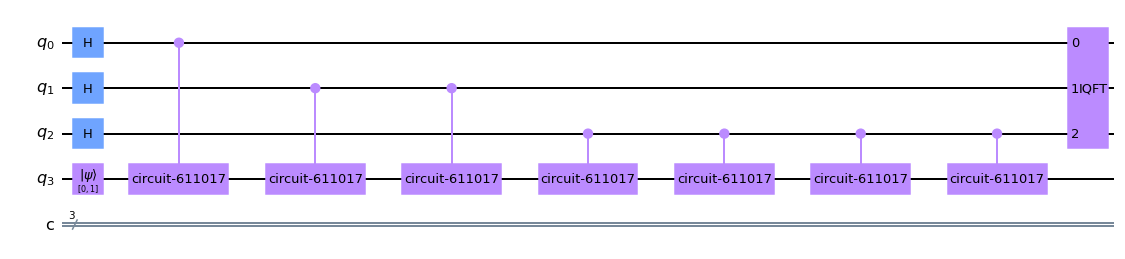

In [61]:
# The Phase Gate using qpe
trotter_number = 1
t = 1
initial_state = [0,1]
cir = QuantumCircuit(1)
cir.t(0)
t_gate = cir.to_gate().control(1)
qpe = my_qpe(3,1, t_gate, initial_state = initial_state)
qpe.draw('mpl')

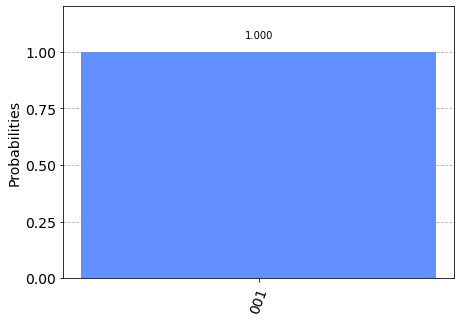

In [62]:
qpe.measure([0,1,2],[0,1,2])
result = execute(qpe, backend = simulator, shots = 8192).result()
count = result.get_counts(qpe)
display(plot_histogram(count))

for T_gate, phase = $\frac{i\pi}{4}$, and phase from QPE we get $\theta = \frac{1}{8}$ $\implies$ phase = $\frac{i\pi}{4}$

# Now let's test it with a simple Ising Hamiltonian 
 Example of Ising Hamiltonian from paper : "[Optimizing quantum phase estimation for the simulation of Hamiltonian eigenstates](https://iopscience.iop.org/article/10.1088/2058-9565/abaa2c)"
 $$H = 0.33Z_0+3.24Z_1+1.17Z_0Z_1$$ 

In [78]:
trotter_number = 2 #we can also choose trotter number 1 here as the all operators in H commute in this case 
t = 1 # delta t, time
hamiltonian = (0.33*t/trotter_number*Z^I)+(3.24*t/trotter_number*I^Z)+(1.17*t/trotter_number*Z^Z)
U = hamiltonian.exp_i() #obtaining the evolution operator for H with t = 1
U = U.to_matrix()
e,v = np.linalg.eig(H) #to match with classical result
e

array([ 4.74+0.j, -4.08+0.j,  1.74+0.j, -2.4 +0.j])

# 1st QPE : My QPE

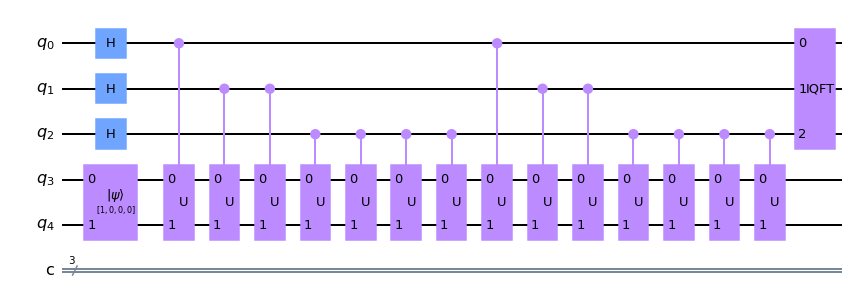

In [79]:
w_qubits = 3
s_qubits = 2
#defining intial state of system as eigenstate
initial_state = list(v[0])
#defining evolution gate(U = e^{iHt}) for H
U_gate = qc(U).to_gate(label = 'U').control(1)
qpe = my_qpe(w_qubits,s_qubits, U_gate, initial_state = initial_state,trotter_number = trotter_number)
qpe.draw('mpl')

In [82]:
qpe.measure([0,1,2],[0,1,2])
result = execute(qpe, backend = simulator, shots = 8192).result()
count = result.get_counts(qpe)
print('Energy eigenvalue for state v[0] is =', plot_to_eigenval(count,t = 1)[1][0])

Energy eigenvalue for state v[0] is = 4.71238898038469


# 2st QPE : Qiskit's In-built

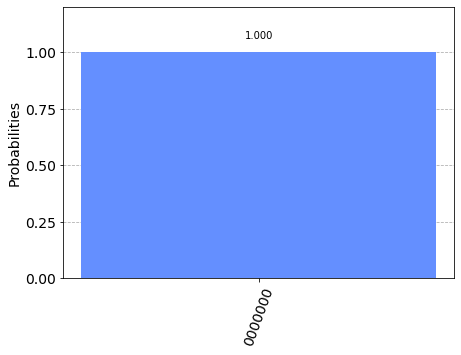

In [85]:
#QPE 1 : In-built QPE
s_qubits = 2
initial_state = random_statevector(2**s_qubits).data
qft = QFT(num_qubits = 3,do_swaps =  True , inverse = True)
qpe = QPE(hamiltonian1,initial_state, qft,  num_time_slices=2, num_ancillae=7)
qpe1 = qpe.construct_circuit(measurement = True)
result = execute(qpe1, backend = simulator, shots = 8192).result()
count = result.get_counts(qpe1)
display(plot_histogram(count))

# 3rd QPE : From David's Github

In [86]:
def exp_all_z(circuit, quantum_register, 
              pauli_idexes, control_qubit=None, t=1):
    """
    The implementation of exp(iZZ..Z t), where Z is 
    the Pauli Z operator, t is a parameter.
    :param circuit: QuantumCircuit.
    :param quantum_register: QuantumRegister.
    :param pauli_idexes: the indexes from quantum_register that 
                         correspond to entries not equal to I: 
                         e.g. if we have XIYZI then the 
                         pauli_idexes = [0,2,3].
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iZZ..Z t).
    """
    # the controlled_exp(iIt) special case
    if len(pauli_idexes) == 0 and control_qubit is not None:
        circuit.add_register(control_qubit.register)
        circuit.u1(t, control_qubit)
        return
        
    # the first CNOTs
    for i in range(len(pauli_idexes) - 1):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])
    
    # Rz gate
    if control_qubit is None:
        circuit.rz(-2 * t, quantum_register[pauli_idexes[-1]])
    else:
        circuit.add_register(control_qubit.register)
        circuit.crz(-2 * t, 
                    control_qubit, quantum_register[pauli_idexes[-1]])
    
    # the second CNOTs
    for i in reversed(range(len(pauli_idexes) - 1)):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])

In [42]:
def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    """
    The circuit for the exp(i P t), where P is the Pauli term, 
    t is the parameter.
    :param pauli: the string for the Pauli term: e.g. "XIXY".
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(i P t).
    :return: QuantumCircuit that implements exp(i P t) or 
             control version of it.
    """
    if len(pauli) != len(quantum_register):
        raise Exception("Pauli string doesn't match to the quantum register")

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u2(np.pi / 2, np.pi / 2, quantum_register[i])
            pauli_idexes.append(i)
    pauli_circuit += circuit_bracket
    exp_all_z(pauli_circuit, quantum_register, pauli_idexes, control_qubit, t)
    pauli_circuit += circuit_bracket

    return pauli_circuit

In [43]:
def hamiltonian_simulation(hamiltonian, quantum_register=None, 
                           control_qubit=None, t=1, trotter_number=1):
    """
    The implementation of exp(iHt), where H is the Hamiltonian 
    operator, t is the parameter.
    :param hamiltonian: dictionary of Pauli terms with their weights: 
                        e.g. {"XZX": 2, "ZYI": 5, "IYZ": 7}.
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iHt).
    :param trotter_number: the Trotter number.
    :return: QuantumCircuit that corresponds to exp(iHt) 
             or control version of it.
    """
    if quantum_register is None:
        quantum_register = QuantumRegister(len(list(hamiltonian.keys())[0]))
    if control_qubit in quantum_register:
        raise Exception("the control qubit is in the target register")

    delta_t = t / trotter_number
    exp_hamiltonian = QuantumCircuit(quantum_register)
    exp_delta_t = QuantumCircuit(quantum_register)
    for pauli in hamiltonian:
        weight = hamiltonian[pauli]
        exp_delta_t += exp_pauli(pauli, quantum_register, 
                                 control_qubit, weight * delta_t)

    for i in range(trotter_number):
        exp_hamiltonian += exp_delta_t

    return exp_hamiltonian

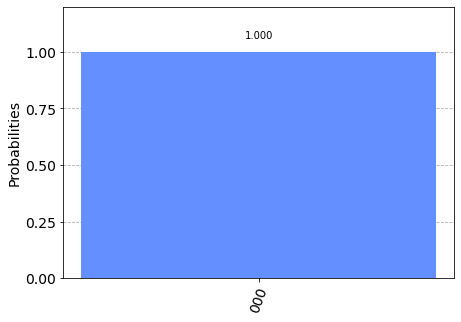

In [88]:
#QPE 3 : The QPE from Github
w_qubits = 3
hamiltonian3 = {"ZI" : 0.33, "IZ" : 3.24, "ZZ" : 1.17}


q = QuantumRegister(s_qubits, name="q")
a = QuantumRegister(w_qubits, name="a") 
c = ClassicalRegister(w_qubits, name="c") 

# Create a quantum circuit
circuit = QuantumCircuit(q, a, c)
circuit.initialize(initial_state,[q[0],q[1]])
circuit = hamiltonian_simulation(hamiltonian3, 
                                 q, t=1/(2*np.pi),trotter_number = 7)
#apply the controlled version of hamiltonian 
qpe3 = QuantumCircuit(a,c)
for ancillary in range(w_qubits):
    qpe3.h(ancillary)

for n in range(w_qubits):
    for m in range(2**n):
        get_controlled_circuit(circuit, a[n], qpe3)
# inverse QFT without SWAP gates
for n in reversed(range(a.size)):
    qpe3.h(a[n])
    if n != 0:
        for m in reversed(range(n)):
            angle = -2*np.pi / (2**(n - m + 1))
            qpe3.cu1(angle, a[n], a[m])

# measurements on the ancillary qubits stored in c classical register
for n in reversed(range(a.size)):
    qpe3.measure(a[n],c[n])
result = execute(qpe3, backend = simulator, shots = 8192).result()
count = result.get_counts(qpe3)
display(plot_histogram(count))

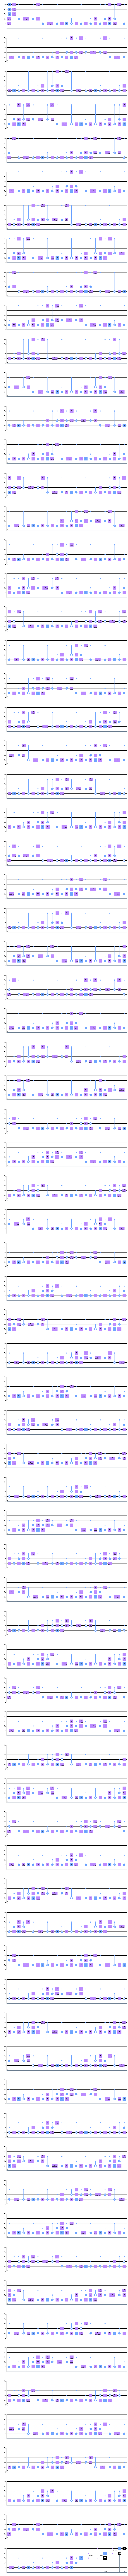

In [ ]:
qpe3.draw('mpl')